In [160]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from statsmodels.graphics.gofplots import qqplot

from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, MinMaxScaler, normalize
from sklearn.compose import make_column_transformer, ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, cross_validate, GridSearchCV

from pylab import rcParams

import tensorflow as tf
from tensorflow import feature_column
from tensorflow.keras import regularizers
from tensorflow.keras import layers

import warnings; 
warnings.simplefilter('ignore')

from IPython.display import display
pd.options.display.float_format = '{:,.2f}'.format
pd.options.display.max_rows = 999

In [50]:
data_train = pd.read_csv('train.csv')
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3865 entries, 0 to 3864
Data columns (total 80 columns):
 #   Column                                                                                   Non-Null Count  Dtype  
---  ------                                                                                   --------------  -----  
 0   galactic year                                                                            3865 non-null   int64  
 1   galaxy                                                                                   3865 non-null   object 
 2   existence expectancy index                                                               3864 non-null   float64
 3   existence expectancy at birth                                                            3864 non-null   float64
 4   Gross income per capita                                                                  3837 non-null   float64
 5   Income Index                                                  

### Корреляции

In [209]:
data_wrk = data_train[data_train['galactic year'] > 1010025].drop(['galactic year', 'galaxy'], axis=1)
#func_list=[np.power()

print('\n', 'Regular', '\n')
display(abs(data_wrk.corrwith(data_wrk['y'])).sort_values(ascending=False).head(10))
print('\n', 'Squared', '\n')
display(abs((data_wrk ** 2).corrwith(data_wrk['y'])).sort_values(ascending=False).head(10))
print('\n', 'Root', '\n')
display(abs((data_wrk ** 1/2).corrwith(data_wrk['y'])).sort_values(ascending=False).head(10))
print('\n', '1/x', '\n')
display(abs((data_wrk ** -1).corrwith(data_wrk['y'])).sort_values(ascending=False).head(10))
print('\n', 'Log', '\n')
display(abs((np.log(data_wrk)).corrwith(data_wrk['y'])).sort_values(ascending=False).head(10))
print('\n', 'Exp', '\n')
display(abs((np.exp(data_wrk)).corrwith(data_wrk['y'])).sort_values(ascending=False).head(10))


 Regular 



y                                                                                  1.00
Gender Inequality Index (GII)                                                      0.73
Estimated gross galactic income per capita, female                                 0.71
Interstellar Data Net users, total (% of population)                               0.71
Intergalactic Development Index (IDI), male, Rank                                  0.70
Intergalactic Development Index (IDI), female, Rank                                0.69
Intergalactic Development Index (IDI), Rank                                        0.68
Old age dependency ratio (old age (65 and older) per 100 creatures (ages 15-64))   0.67
Intergalactic Development Index (IDI), male                                        0.65
Gross galactic product (GGP) per capita                                            0.65
dtype: float64


 Squared 



y                                                                                  0.93
Interstellar Data Net users, total (% of population)                               0.76
Intergalactic Development Index (IDI), male                                        0.69
Intergalactic Development Index (IDI), female                                      0.68
Expected years of education (galactic years)                                       0.67
Education Index                                                                    0.67
Old age dependency ratio (old age (65 and older) per 100 creatures (ages 15-64))   0.67
Estimated gross galactic income per capita, female                                 0.66
Intergalactic Development Index (IDI)                                              0.66
Gender Inequality Index (GII)                                                      0.66
dtype: float64


 Root 



y                                                                                  1.00
Gender Inequality Index (GII)                                                      0.73
Estimated gross galactic income per capita, female                                 0.71
Interstellar Data Net users, total (% of population)                               0.71
Intergalactic Development Index (IDI), male, Rank                                  0.70
Intergalactic Development Index (IDI), female, Rank                                0.69
Intergalactic Development Index (IDI), Rank                                        0.68
Old age dependency ratio (old age (65 and older) per 100 creatures (ages 15-64))   0.67
Intergalactic Development Index (IDI), male                                        0.65
Gross galactic product (GGP) per capita                                            0.65
dtype: float64


 1/x 



Gender Inequality Index (GII)                                          0.75
Intergalactic Development Index (IDI), female, Rank                    0.73
Intergalactic Development Index (IDI), male, Rank                      0.73
Intergalactic Development Index (IDI), Rank                            0.72
y                                                                      0.70
Adolescent birth rate (births per 1,000 female creatures ages 15-19)   0.58
Intergalactic Development Index (IDI), male                            0.56
Mortality rate, male grown up (per 1,000 people)                       0.55
Young age (0-14) dependency ratio (per 100 creatures ages 15-64)       0.55
Intergalactic Development Index (IDI)                                  0.54
dtype: float64


 Log 



y                                                                                  0.91
Gender Inequality Index (GII)                                                      0.78
Intergalactic Development Index (IDI), male, Rank                                  0.75
Intergalactic Development Index (IDI), female, Rank                                0.74
Intergalactic Development Index (IDI), Rank                                        0.74
Estimated gross galactic income per capita, female                                 0.67
Gross galactic product (GGP) per capita                                            0.62
Old age dependency ratio (old age (65 and older) per 100 creatures (ages 15-64))   0.62
Interstellar Data Net users, total (% of population)                               0.62
Intergalactic Development Index (IDI), male                                        0.61
dtype: float64


 Exp 



y                                                  1.00
Gender Inequality Index (GII)                      0.70
Intergalactic Development Index (IDI), male        0.68
Intergalactic Development Index (IDI), female      0.67
Education Index                                    0.67
Intergalactic Development Index (IDI)              0.66
Income Index                                       0.62
existence expectancy index                         0.57
Mean years of education, female (galactic years)   0.46
Mean years of education, male (galactic years)     0.44
dtype: float64

In [51]:
#@title Отрицательные значения
cols_sub_zero = []
cols_sub_zero.extend([x for x in data_train.columns if (data_train[x].dtype in ['float64', 'int64'] and data_train[x].min() < 0)])
(data_train[cols_sub_zero] < 0).sum()
# data_train['galaxy'] == 'Andromeda XV'
# data_train.loc[data_train['galaxy'] == 'Andromeda XV'][['galactic year', 'galaxy', 'Population, total (millions)', 'y']]#.describe()

Gross income per capita                                                             1
Population, total (millions)                                                        1
Population, ages 15–64 (millions)                                                   1
Population, ages 65 and older (millions)                                            1
Population, under age 5 (millions)                                                  3
Employment in agriculture (% of total employment)                                   1
Infants lacking immunization, Combination Vaccine (% of one-galactic year-olds)     1
Gross galactic product (GGP), total                                                 1
Outer Galaxies direct investment, net inflows (% of GGP)                            2
Natural resource depletion                                                          1
Renewable energy consumption (% of total final energy consumption)                  1
Estimated gross galactic income per capita, female    

 По ряду признаков есть отрицательные значения. Судя по названию признаков, они не должны принимать отрицательных значений. Рассмотрим подробнее:

In [52]:
# Gross income per capita < 0
data_train[data_train['galaxy'] == 'KUG 1210+301B (KK98 127)'].transpose()

,21,258,393,684,786,936,1104,1436,1534,1793,...,2268,2439,2665,2853,2885,3069,3230,3258,3398,3441
galactic year,990025,991020,992016,993012,994009,995006,996004,997002,998001,999000,...,1002001,1003002,1004004,1005006,1006009,1007012,1008016,1009020,1010025,1011030
galaxy,KUG 1210+301B (KK98 127),KUG 1210+301B (KK98 127),KUG 1210+301B (KK98 127),KUG 1210+301B (KK98 127),KUG 1210+301B (KK98 127),KUG 1210+301B (KK98 127),KUG 1210+301B (KK98 127),KUG 1210+301B (KK98 127),KUG 1210+301B (KK98 127),KUG 1210+301B (KK98 127),...,KUG 1210+301B (KK98 127),KUG 1210+301B (KK98 127),KUG 1210+301B (KK98 127),KUG 1210+301B (KK98 127),KUG 1210+301B (KK98 127),KUG 1210+301B (KK98 127),KUG 1210+301B (KK98 127),KUG 1210+301B (KK98 127),KUG 1210+301B (KK98 127),KUG 1210+301B (KK98 127)
existence expectancy index,0.65,0.66,0.66,0.63,0.77,0.75,0.79,0.79,0.76,0.79,...,0.79,0.91,0.80,0.92,0.88,0.84,1.00,0.81,0.89,0.87
existence expectancy at birth,62.80,64.12,61.30,65.54,63.73,70.16,74.29,73.66,70.24,70.34,...,75.13,72.47,72.89,76.14,75.78,78.18,69.63,67.80,72.52,77.16
Gross income per capita,"16,163.48","19,366.92","10,020.83","25,719.62","12,107.58","21,016.76","20,291.68","24,997.28","13,571.53","19,388.60",...,"18,650.96","19,087.83","18,252.54","17,403.82","18,159.03",-126.91,"14,494.83","23,487.98","24,332.91","16,473.18"
Income Index,0.47,0.53,0.67,0.62,0.58,0.56,0.64,0.58,0.62,0.51,...,0.60,0.69,0.55,0.57,0.62,0.56,0.57,0.65,0.51,0.60
Expected years of education (galactic years),11.49,11.85,10.47,12.16,12.38,11.33,10.89,12.84,11.99,12.63,...,11.40,11.09,12.28,11.34,12.49,14.33,15.90,12.79,16.87,13.96
Mean years of education (galactic years),4.42,3.76,4.71,5.62,3.85,5.05,5.30,6.33,3.92,4.87,...,4.91,5.96,6.15,6.31,8.34,7.09,6.34,6.55,5.96,5.30
Intergalactic Development Index (IDI),0.56,0.62,0.61,0.43,0.51,0.54,0.59,0.50,0.67,0.64,...,0.68,0.60,0.65,0.63,0.75,0.68,0.70,0.69,0.67,0.70
Education Index,0.43,0.44,0.54,0.50,0.46,0.43,0.71,0.46,0.57,0.48,...,0.57,0.58,0.50,0.51,0.45,0.62,0.57,0.67,0.60,0.62


### Отрицательные значения

,Gross income per capita,"Population, total (millions)","Population, ages 15–64 (millions)","Population, ages 65 and older (millions)","Population, under age 5 (millions)",Employment in agriculture (% of total employment),"Infants lacking immunization, Combination Vaccine (% of one-galactic year-olds)","Gross galactic product (GGP), total","Outer Galaxies direct investment, net inflows (% of GGP)",Natural resource depletion,Renewable energy consumption (% of total final energy consumption),"Estimated gross galactic income per capita, female",Domestic credit provided by financial sector (% of GGP),"Remittances, inflows (% of GGP)",Intergalactic inbound tourists (thousands),Adjusted net savings,"Creature Immunodeficiency Disease prevalence, adult (% ages 15-49), total",Private galaxy capital flows (% of GGP)
count,"3,837.00","1,271.00","1,264.00","1,264.00","1,264.00","1,237.00","1,219.00","1,202.00","1,169.00","1,132.00","1,235.00","1,055.00","1,079.00","1,028.00",995.00,912.00,941.00,874.00
mean,"31,633.24",891.29,578.33,65.07,89.53,54.03,18.80,"7,749.98",18.34,13.77,63.73,"23,037.55",118.69,11.93,"115,534.30",21.25,6.44,22.26
std,"18,736.38",894.15,571.04,63.14,89.71,25.16,11.51,"7,167.78",15.38,9.60,32.25,"13,075.77",61.43,9.02,"113,381.55",14.26,4.80,34.34
min,-126.91,-160.44,-91.29,-23.66,-2.09,-0.68,-1.32,-933.22,-5.27,-0.37,-1.05,-947.54,-38.30,-0.08,"-9,669.28",-76.74,-1.19,-735.19
25%,"20,169.12",599.65,393.56,43.45,60.16,34.15,11.91,"5,479.46",13.02,8.62,38.02,"14,589.01",78.54,7.42,"78,249.62",15.00,4.11,17.23
50%,"26,600.77",774.11,501.29,56.85,77.69,49.54,15.34,"7,130.47",16.75,11.28,55.31,"19,431.72",104.42,10.04,"101,776.45",22.18,5.31,24.47
75%,"36,898.63",952.23,614.06,69.75,95.08,71.63,21.36,"8,786.80",20.93,15.55,87.35,"27,312.73",145.76,13.23,"124,652.54",29.13,6.81,31.75
max,"151,072.68","7,993.32","5,542.81",649.49,780.96,131.09,72.43,"112,391.32",362.55,100.41,146.13,"83,638.78",555.80,172.73,"1,228,843.07",61.90,36.54,95.94


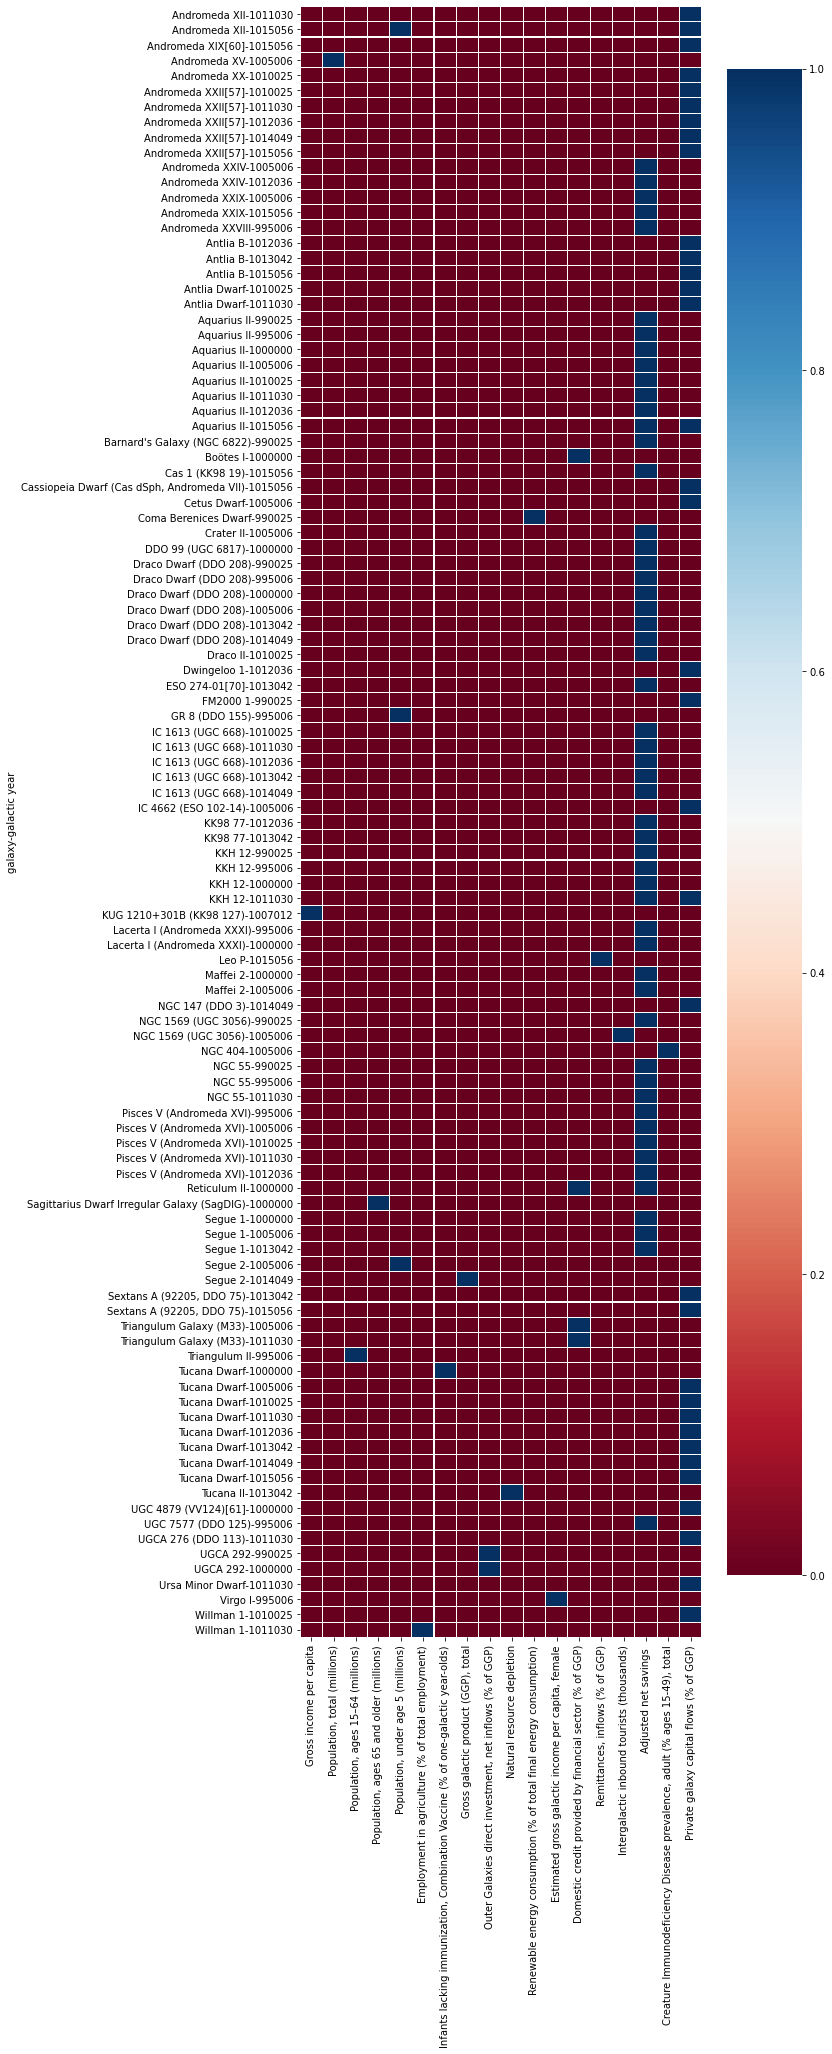

In [210]:
rcParams['figure.figsize'] = 9, 30
data_train_subzero_cols = [x for x in data_train.columns if \
                           (data_train[x].dtype in ['float64', 'int64'] and data_train[x].min() < 0)]
data_train_subzero = data_train[(data_train.drop('galaxy', axis=1) < 0).any(axis=1)][['galaxy', 'galactic year'] + data_train_subzero_cols]
sns.heatmap(data_train_subzero.set_index(['galaxy', 'galactic year']).sort_index() < 0, cmap="RdBu", linewidths=0.05)
display(data_train[data_train_subzero_cols].describe(include='all'))


### Значения NaN

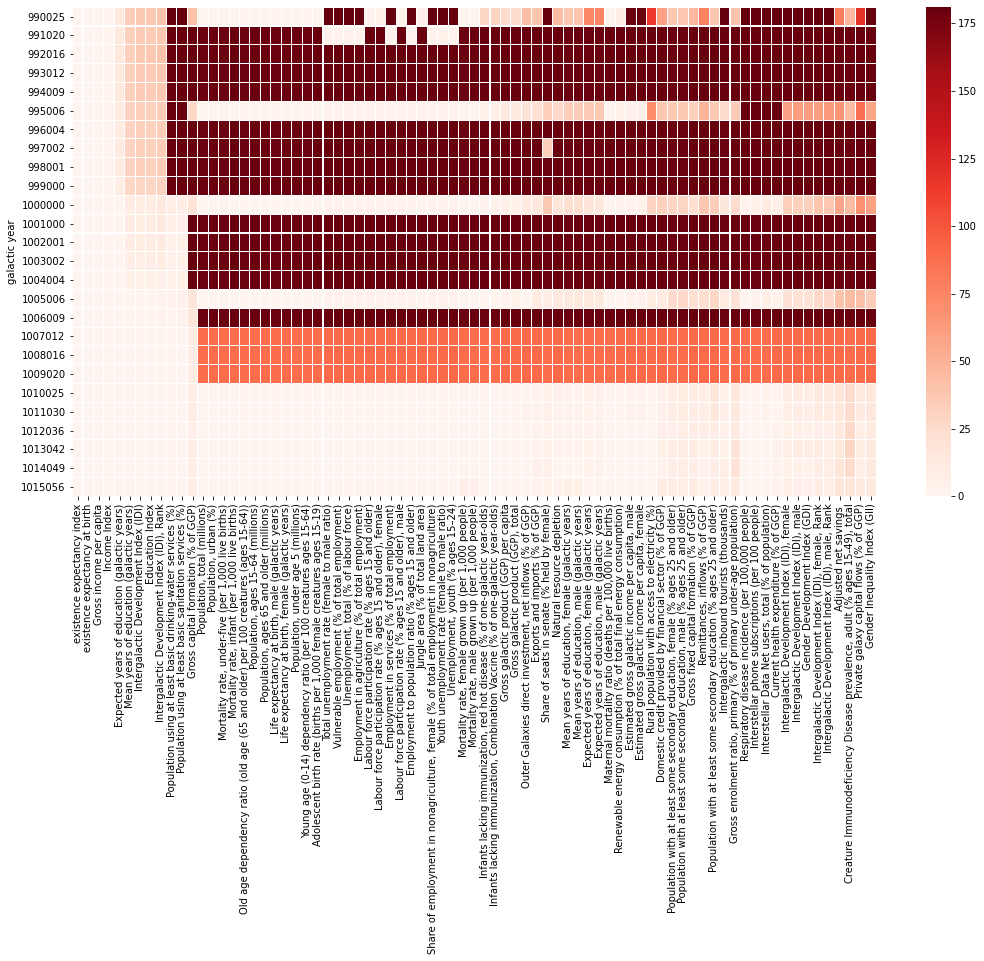

In [211]:
# Кол-во стран с незаполненными атрибутами по года
rcParams['figure.figsize'] = 18, 9

cols_nan = [x for x in data_train.columns if any((data_train[x] != data_train[x]))]
sns.heatmap((data_train[['galactic year']].join(data_train[cols_nan] != data_train[cols_nan])).groupby('galactic year').sum(),
           cmap="Reds", linewidths=0.05);
# data_train['galaxy'] == 'Andromeda XV'
# data_train.loc[data_train['galaxy'] == 'Andromeda XV'][['galactic year', 'galaxy', 'Population, total (millions)', 'y']]#.describe()

In [231]:
% fgfdgdfg
def data_desc(data, cols=[], start_col=0, n_cols=10):
    """Description for data
    data - Dataset;
    cols - Columns for subset;
    start_col - Start No. of column subset;
    n_cols - Number of columns in subset. Default 10 for good screen fitting;
    """
    if not cols:
        i = start_col
        cols = list(data.drop(['galaxy', 'galactic year'], axis=1).columns[start_col:min(data.shape[1], start_col + n_cols)])
    print('Data head:', '\n')
    display(data[cols].head(10))
    print('Data description:', '\n')
    display(data[cols].describe(include='all'))
    print('Data fullness:', '\n')
    display(data.groupby(['galactic year'])[['galaxy'] + cols].count())
    rcParams['figure.figsize'] = 18, 9
    print('Data distribution:', '\n')
    data[cols].hist();
    plt.show()
    fig, ax = plt.subplots(4, 3, figsize=(16, 12))
    for i, c in enumerate(cols):
        data_wrk = data[c]
        qqplot(data_wrk, line='s', ax=ax[i//3, i%3])
    plt.show()
    print('Data correlation:', '\n')
    display(data[cols].corrwith(data['y']))
    print()
    sns.heatmap(data[cols + ['y']].corr(), cmap="RdYlBu", vmin=-1, vmax=1)
    print('\n', '-' * 50, '\n')

Data head: 



,existence expectancy index,existence expectancy at birth,Gross income per capita,Income Index,Expected years of education (galactic years),Mean years of education (galactic years),Intergalactic Development Index (IDI),Education Index,"Intergalactic Development Index (IDI), Rank",Population using at least basic drinking-water services (%)
0,0.63,63.13,"27,109.23",0.65,8.24,nan,nan,nan,nan,nan
1,0.82,81.00,"30,166.79",0.85,10.67,4.74,0.83,0.47,152.52,nan
2,0.66,59.57,"8,441.71",0.50,8.84,5.58,0.47,0.36,209.81,nan
3,0.56,52.33,nan,nan,nan,nan,nan,nan,nan,nan
4,0.99,81.80,"81,033.96",1.13,13.80,13.19,0.91,0.92,71.89,nan
5,0.82,63.89,"28,409.06",0.67,14.06,9.98,0.82,0.80,121.84,nan
6,0.66,68.56,"25,648.33",0.75,15.43,10.02,0.66,0.74,149.57,nan
7,0.95,75.69,"20,935.54",0.95,14.86,nan,nan,nan,nan,nan
8,0.66,61.34,"18,231.03",0.83,15.17,6.94,0.73,0.65,168.49,nan
9,0.66,62.55,"16,196.13",0.68,12.94,6.53,0.56,0.48,154.10,nan


Data description: 



,existence expectancy index,existence expectancy at birth,Gross income per capita,Income Index,Expected years of education (galactic years),Mean years of education (galactic years),Intergalactic Development Index (IDI),Education Index,"Intergalactic Development Index (IDI), Rank",Population using at least basic drinking-water services (%)
count,"3,864.00","3,864.00","3,837.00","3,837.00","3,732.00","3,502.00","3,474.00","3,474.00","3,432.00","2,021.00"
mean,0.87,76.80,"31,633.24",0.83,14.72,10.28,0.80,0.75,135.13,101.89
std,0.16,10.46,"18,736.38",0.19,3.61,3.32,0.18,0.20,52.45,20.32
min,0.23,34.24,-126.91,0.29,3.80,1.93,0.27,0.19,9.93,33.14
25%,0.76,69.96,"20,169.12",0.68,12.59,7.65,0.67,0.60,92.26,89.47
50%,0.91,79.00,"26,600.77",0.83,14.94,10.39,0.82,0.76,135.91,108.42
75%,0.99,84.56,"36,898.63",0.97,17.12,12.88,0.94,0.89,175.30,116.90
max,1.25,100.21,"151,072.68",1.36,26.96,19.06,1.23,1.27,278.79,136.32


Data fullness: 



,galaxy,existence expectancy index,existence expectancy at birth,Gross income per capita,Income Index,Expected years of education (galactic years),Mean years of education (galactic years),Intergalactic Development Index (IDI),Education Index,"Intergalactic Development Index (IDI), Rank",Population using at least basic drinking-water services (%)
galactic year,,,,,,,,,,,
990025,181,180,180,179,179,167,147,144,144,141,0
991020,180,180,180,178,178,167,147,144,144,142,0
992016,180,180,180,178,178,166,147,143,143,139,0
993012,180,180,180,178,178,167,147,144,144,142,0
994009,180,180,180,178,178,167,147,144,144,142,0
995006,180,180,180,178,178,169,150,148,148,146,0
996004,180,180,180,178,178,169,150,148,148,146,0
997002,180,180,180,178,178,168,150,147,147,146,0
998001,180,180,180,178,178,169,150,148,148,146,0


Data distribution: 



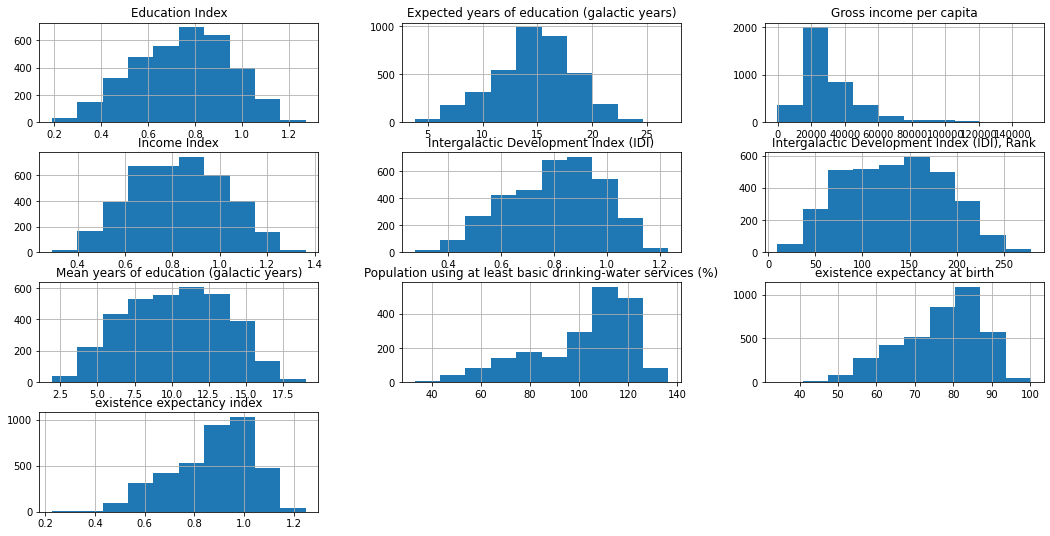

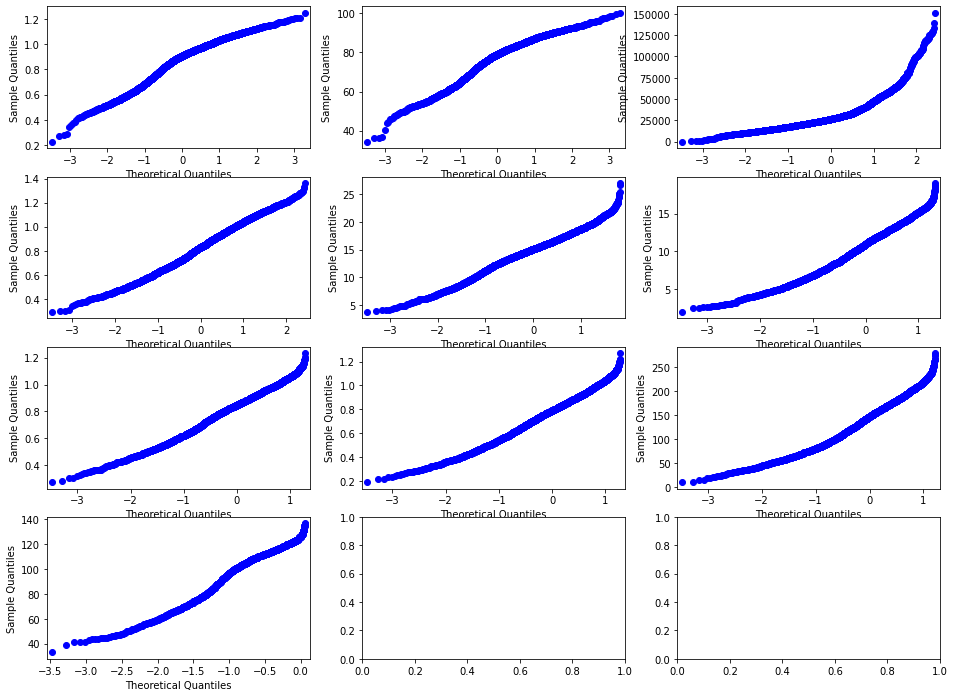

Data correlation: 



existence expectancy index                                     0.55
existence expectancy at birth                                  0.56
Gross income per capita                                        0.51
Income Index                                                   0.58
Expected years of education (galactic years)                   0.58
Mean years of education (galactic years)                       0.58
Intergalactic Development Index (IDI)                          0.63
Education Index                                                0.61
Intergalactic Development Index (IDI), Rank                   -0.68
Population using at least basic drinking-water services (%)    0.43
dtype: float64



 -------------------------------------------------- 



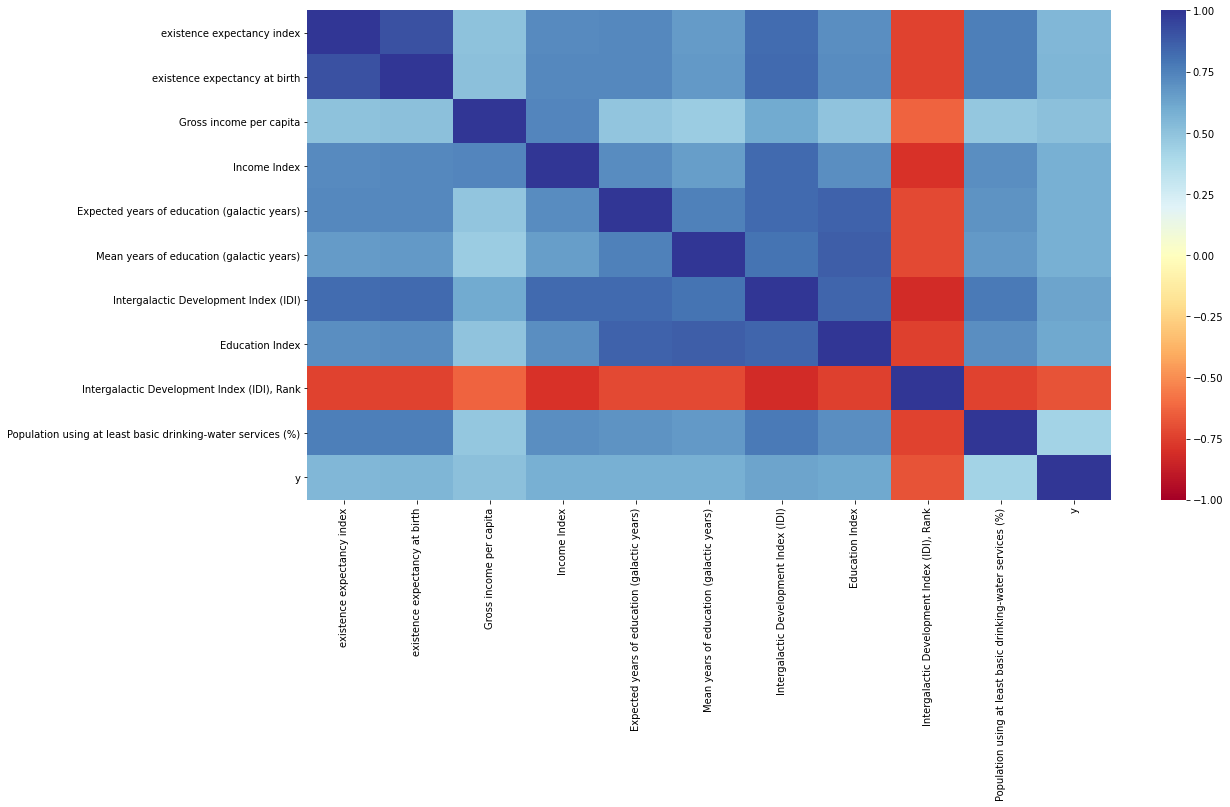

In [230]:
data_desc(data_train, 0)

In [179]:
from scipy.stats import shapiro, normaltest, anderson
col = 'Education Index'

col_data = data_train[data_train[col] == data_train[col]][col]

stat, p = shapiro(col_data)
print(stat, p)
stat, p = normaltest(col_data)
print(stat, p)
result = anderson(col_data)
print('Statistic: %.3f' % result.statistic)
p = 0
for i in range(len(result.critical_values)):
	sl, cv = result.significance_level[i], result.critical_values[i]
	if result.statistic < result.critical_values[i]:
		print('%.3f: %.3f, data looks normal (fail to reject H0)' % (sl, cv))
	else:
		print('%.3f: %.3f, data does not look normal (reject H0)' % (sl, cv))

0.9898264408111572 4.416008388092663e-15
144.7067651684407 3.778550201901903e-32
Statistic: 8.674
15.000: 0.575, data does not look normal (reject H0)
10.000: 0.655, data does not look normal (reject H0)
5.000: 0.786, data does not look normal (reject H0)
2.500: 0.917, data does not look normal (reject H0)
1.000: 1.091, data does not look normal (reject H0)


Признаки, в которых есть незаполненные строки.

cols_percent = [x for x in data_train.columns if ('%' in x)]
cols_percent = [x for x in cols_percent if (any(data_train[x] > 100))]
(data_train[cols_percent] > 100).sum()

Будем считать, что у инопланетян другие проценты с максимумом > 100%

In [193]:
train_df, test_df = train_test_split(data_train[data_train['galactic year'] >= 1010025], test_size=0.2, random_state=163)
print(train_df.shape, test_df.shape);
train_df.drop(['galaxy'], axis=1, inplace=True)
test_df.drop(['galaxy'], axis=1, inplace=True)
test_df = test_df.where(test_df > 0, np.abs)
train_df = train_df.where(train_df > 0, np.abs)
train_df.fillna(train_df.mean(), inplace=True);
test_df.fillna(test_df.mean(), inplace=True);

train_df_min = train_df.iloc[:,:-1].min()
train_df_max = train_df.iloc[:,:-1].max()
train_df.iloc[:,:-1] = (train_df.iloc[:,:-1] - train_df_min)/train_df_max

test_df_mean = test_df.iloc[:,:-1].min()
test_df_std = test_df.iloc[:,:-1].max()
test_df.iloc[:,:-1] = (test_df.iloc[:,:-1] - train_df_min)/train_df_max


rename_cols = dict()
for i, cn in enumerate(data_train.columns):
    if cn not in ['galaxy', 'galactic year', 'y']:
        rename_cols[cn] = 'col_' + str(i)

train_df.rename(columns=rename_cols, inplace=True)
test_df.rename(columns=rename_cols, inplace=True)

from sklearn.utils import shuffle
train_df = shuffle(train_df, random_state=42)

print(train_df.shape, test_df.shape);

(427, 80) (107, 80)
(427, 79) (107, 79)


In [194]:
# Create an empty list that will eventually hold all feature columns.
feature_columns = []

for x in train_df.columns:
    if x not in ['galaxy', 'galactic year', 'y']:        
        feature_columns.append(tf.feature_column.numeric_column(x))
fp_feature_layer = layers.DenseFeatures(feature_columns)

In [267]:
#@title Define functions to create and train a model, and a plotting function
def create_model(my_learning_rate, feature_layer):
    """Create and compile a simple linear regression model."""
  # Most simple tf.keras models are sequential.
    model = tf.keras.models.Sequential()

  # Add the layer containing the feature columns to the model.
    model.add(feature_layer)

  # Add one linear layer to the model to yield a simple linear regressor.
    #model.add(tf.keras.layers.Multiply()([model[-1], model[-1]]))
    model.add(tf.keras.layers.Dense(units=1, input_shape=(80,), 
                                    kernel_regularizer=regularizers.l1_l2(l1=1e-4, l2=1e-6),
                                    bias_regularizer=regularizers.l2(1e-8),
                                    activity_regularizer=regularizers.l2(1e-8)
                                   ))
    #model.add(tf.keras.layers.Multiply())
    #model.add(tf.keras.layers.Dense(units=1, input_shape=(10,)))
    model.add(tf.keras.layers.Dense(units=1, input_shape=(40,)))
    model.add(tf.keras.layers.Dense(units=1, input_shape=(15,)))
    model.add(tf.keras.layers.Dense(units=1, input_shape=(1,), activation='softplus'))

  # Construct the layers into a model that TensorFlow can execute.
    model.compile(optimizer='adam',#tf.keras.optimizers.RMSprop(lr=my_learning_rate),
                loss="mean_squared_error",
                metrics=[tf.keras.metrics.RootMeanSquaredError()])

    return model           


def train_model(model, dataset, epochs, batch_size, label_name):
    """Feed a dataset into the model in order to train it."""

    features = {name:np.array(value) for name, value in dataset.items()}
    label = np.array(features.pop(label_name))
    history = model.fit(x=features, y=label, batch_size=batch_size,
                      epochs=epochs, shuffle=True, validation_split=0.2)

    # The list of epochs is stored separately from the rest of history.
    epochs = history.epoch

    # Isolate the mean absolute error for each epoch.
    hist = pd.DataFrame(history.history)
    rmse = hist[["root_mean_squared_error", "val_root_mean_squared_error"]]

    return epochs, rmse   


def plot_the_loss_curve(epochs, rmse):
    """Plot a curve of loss vs. epoch."""

    plt.figure()
    plt.xlabel("Epoch")
    plt.ylabel("Root Mean Squared Error")

    plt.plot(epochs, rmse, label=list(rmse.columns))
    plt.legend(list(rmse.columns))
    plt.ylim([min(rmse.min())*0.94, max(rmse.max())* 1.05])
    plt.show()  

print("Defined the create_model, train_model, and plot_the_loss_curve functions.")

Defined the create_model, train_model, and plot_the_loss_curve functions.


Epoch 1/300
341/341 [==============================] - 3s 8ms/step - loss: 0.0885 - root_mean_squared_error: 0.2954 - val_loss: 0.0168 - val_root_mean_squared_error: 0.1242
Epoch 2/300
341/341 [==============================] - 2s 4ms/step - loss: 0.0141 - root_mean_squared_error: 0.1127 - val_loss: 0.0155 - val_root_mean_squared_error: 0.1190
Epoch 3/300
341/341 [==============================] - 2s 4ms/step - loss: 0.0131 - root_mean_squared_error: 0.1080 - val_loss: 0.0145 - val_root_mean_squared_error: 0.1147
Epoch 4/300
341/341 [==============================] - 2s 5ms/step - loss: 0.0121 - root_mean_squared_error: 0.1033 - val_loss: 0.0132 - val_root_mean_squared_error: 0.1087
Epoch 5/300
341/341 [==============================] - 2s 5ms/step - loss: 0.0106 - root_mean_squared_error: 0.0963 - val_loss: 0.0114 - val_root_mean_squared_error: 0.1003
Epoch 6/300
341/341 [==============================] - 2s 5ms/step - loss: 0.0091 - root_mean_squared_error: 0.0880 - val_loss: 0.0096 

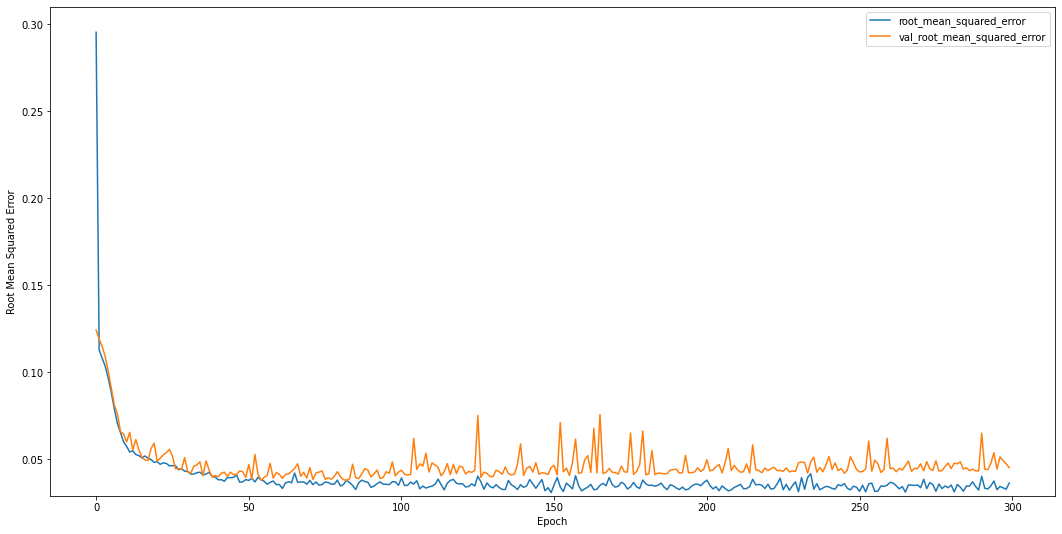


: Evaluate the new model against the test set:
107/107 [==============================] - 1s 6ms/step - loss: 0.0013 - root_mean_squared_error: 0.0260


[0.0013008152600377798, 0.025980403646826744]

In [268]:
# The following variables are the hyperparameters.
learning_rate = 0.000003
epochs = 300
batch_size = 1
label_name = 'y'

# Create and compile the model's topography.
my_model = create_model(learning_rate, fp_feature_layer)

# Train the model on the training set.
epochs, rmse = train_model(my_model, train_df, epochs, batch_size, label_name)

plot_the_loss_curve(epochs, rmse)

print("\n: Evaluate the new model against the test set:")
test_features = {name:np.array(value) for name, value in test_df.items()}
test_label = np.array(test_features.pop(label_name))
my_model.evaluate(x=test_features, y=test_label, batch_size=batch_size)

In [215]:
test = pd.DataFrame()
test['p'] = my_model.predict(test_features).reshape(1,-1)[0]
test['o'] = test_df['y'].values

In [216]:
test.agg(['max', 'min'])

,p,o
max,0.36,0.34
min,0.01,0.02


0      0.03
1      0.05
2      0.05
3      0.05
4      0.02
5      0.01
6      0.02
7      0.05
8      0.05
9      0.02
10     0.07
11     0.02
12     0.05
13     0.04
14     0.01
15     0.04
16     0.02
17     0.03
18     0.05
19     0.05
20     0.02
21     0.01
22     0.04
23     0.01
24     0.05
25     0.04
26     0.03
27     0.03
28     0.05
29     0.02
30     0.07
31     0.04
32     0.05
33     0.05
34     0.01
35     0.06
36     0.05
37     0.03
38     0.02
39     0.03
40     0.05
41     0.02
42     0.02
43     0.05
44     0.05
45     0.03
46     0.05
47     0.01
48     0.01
49     0.04
50     0.05
51     0.07
52     0.01
53     0.05
54     0.04
55     0.01
56     0.02
57     0.01
58     0.05
59     0.05
60     0.02
61     0.05
62     0.02
63     0.02
64     0.02
65     0.06
66     0.06
67     0.00
68     0.06
69     0.05
70     0.05
71     0.03
72     0.01
73     0.02
74     0.04
75     0.05
76     0.03
77     0.05
78     0.00
79     0.02
80     0.06
81     0.04
82     0.07
83  

In [266]:
from scipy.optimize import Bounds
from scipy.optimize import LinearConstraint
from scipy.optimize import minimize
import numpy as np
import pandas as pd

pred = pd.read_csv('submit.csv')['pred']
data_test = pd.read_csv('test.csv')
sz = len(pred)

def func_en(En):
    print(-sum(En * ((-np.log(pred + 0.01) + 3) ** 2 / 1000)))
    return -sum(En * ((-np.log(pred + 0.01) + 3) ** 2 / 1000))

bounds = Bounds(0, 1)
linear_constraint = LinearConstraint([np.array(data_test['existence expectancy index'] < 0.7).astype('float'),
                                      np.ones(sz)], [50, 0], [np.inf, 500])

En0 = np.random.random(sz)
res = minimize(func_en, En0, method='trust-constr', jac='2-point', \
                   constraints=[linear_constraint], \
                   options={'verbose': 1}, bounds=bounds)

-15.368683965039237
-15.368683965574917
-15.368683965574917
-15.368683965574917
-15.368683965574917
-15.368683965751156
-15.368683965751156
-15.368683965751156
-15.368683965574917
-15.368683965574917
-15.368683965751156
-15.368683965542834
-15.368683965751156
-15.368683965542834
-15.368683965574917
-15.368683965751156
-15.368683965670082
-15.368683965751156
-15.368683965670082
-15.368683965574917
-15.368683965574917
-15.368683965751156
-15.368683965751156
-15.368683965574917
-15.368683965751156
-15.368683965574917
-15.368683965670083
-15.368683965751156
-15.368683965670083
-15.368683965574917
-15.368683965670082
-15.368683965574917
-15.368683965574917
-15.368683965574917
-15.368683965574917
-15.368683965751156
-15.368683965574917
-15.368683965574917
-15.368683965751156
-15.368683965751156
-15.368683965670082
-15.368683965574917
-15.368683965751156
-15.368683965751156
-15.368683965574917
-15.368683965574917
-15.368683965751156
-15.368683965574917
-15.3686839659011
-15.3686839659011
-15.

In [259]:
data_test = pd.read_csv('test.csv')

data_test.drop('galaxy', axis=1, inplace=True)
data_test = data_test.where(data_test > 0, np.abs)
data_test.fillna(data_test.mean(), inplace=True);

data_test_min = data_test.min()
data_test_max = data_test.max()
data_test = (data_test - data_test_min)/data_test_max

data_test.rename(columns=rename_cols, inplace=True)

data_test_features = {name:np.array(value) for name, value in data_test.items()}

In [263]:
data_submit = pd.DataFrame()
data_submit['pred'] = my_model.predict(data_test_features).reshape(1,-1)[0]
data_submit['opt_pred'] = 0

In [264]:
data_submit.reset_index().to_csv('submit.csv', index=False, float_format='%.2f')